In [161]:
# External modules
import os.path
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

start = time.time()


# Internal modules
import results
from initialize_model import m, S, V_meta
from global_param import Costs_u, Periods, Ext_T, Irradiance
import model
import data

In [162]:
def var_names(m):
    var_name_time_indep, var_name_time_dep = [], []
    number = np.arange(0, 10).tolist()
    number = [str(n) for n in number]
    
    # get all variable names, store the time dependent ones and cut the period index
    for v in m.getVars():
        if all(n not in v.varName for n in number):
            if ',0' in v.varName:
                var_name_time_dep.append(v.varName.split(',0')[0])
            elif '[0' in v.varName:
                var_name_time_dep.append(v.varName.split('[0')[0])
            else:
                var_name_time_indep.append(v.varName)
                   
    return var_name_time_indep, var_name_time_dep


def var_results(m, Periods):
    var_result_time_indep, var_result_time_dep = {}, {}

    number = np.arange(0, 10).tolist()
    number = [str(n) for n in number]
    
    for v in m.getVars():
        results = []
        if ',0' in v.varName:
            name = v.varName.split(',0')[0]
            for p in Periods:
                results.append(m.getVarByName(name + ',{}]'.format(p)).x)
            var_result_time_dep[name + ']'] = results
        elif '[0' in v.varName:
            name = v.varName.split('[0')[0]
            for p in Periods:
                results.append(m.getVarByName(name + '[{}]'.format(p)).x)
            var_result_time_dep[name] = results
        elif all(n not in v.varName for n in number):
            var_result_time_indep[v.varName] = v.x
            
    return var_result_time_indep, var_result_time_dep

In [163]:
# Build and run the MIP optimization model
relax = False
model.run(relax)

end = time.time()
print('solve time model: ', end - start, 's')

var_result_time_indep, var_result_time_dep = var_results(m, Periods)
var_name_time_indep, var_name_time_dep = var_result_time_indep.keys(), var_result_time_dep.keys()

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 848 rows, 772 columns and 2134 nonzeros
Model fingerprint: 0x8408e901
Model has 26 general constraints
Variable types: 719 continuous, 53 integer (53 binary)
Coefficient statistics:
  Matrix range     [3e-05, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+04]
  RHS range        [4e-03, 1e+03]

MIP start from previous solve produced solution with objective 0.0507531 (0.01s)
Loaded MIP start from previous solve with objective 0.0507531

Presolve removed 501 rows and 394 columns
Presolve time: 0.00s
Presolved: 347 rows, 378 columns, 1214 nonzeros
Variable types: 357 continuous, 21 integer (21 binary)

Root relaxation: objective 5.068717e-02, 268 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0506872    0.05069  0.00%     -   

In [164]:
var_result_time_indep

{'size[BOI]': 476.5733082655599,
 'size[PV]': 60.0,
 'size[BAT]': 20.0,
 'size[SOFC]': 20.0,
 'size[AD]': 116.99999999999919,
 'install[BOI]': 1.0,
 'install[PV]': 1.0,
 'install[BAT]': 1.0,
 'install[SOFC]': 1.0,
 'install[AD]': 1.0,
 'capex[BOI]': 96.91235526219083,
 'capex[PV]': 215.26715000000004,
 'capex[BAT]': 26.6266,
 'capex[SOFC]': 103.57560000000001,
 'capex[AD]': 324.8999999999978,
 'min_T_AD': 30.0,
 'max_T_AD': 40.0,
 'penalty': 3.620508613031688e-05,
 'grid_elec_export': 0.04999438814603528,
 'grid_elec_import': 1.7473035925573985,
 'grid_gas_import': 12.708621553748264,
 'grid_gas_export': 0.0,
 'capex': 0.7672817052621888,
 'opex': 0.0014320430354619542,
 'totex': 0.05065096135852281}

In [165]:
def get_unit_name(var):
    return var.split('[')[1].split(']')[0]

Units_storage = ['BAT']
Color_code = {'BOI': 'firebrick', 'PV': 'aqua', 'BAT': 'navy', 
              'SOFC': 'red', 'AD': 'darkgreen'}
Units = ['BOI', 'PV', 'BAT', 'SOFC', 'AD']

def plot_unit_results(var_result_time_indep, Units, Units_storage, Color_code):
    """ Given a dictionnary of time independent results plot a bar chart of the size of units
        in kW of production capacity for non-storage units and in kWh for storage units.
    """

    fig, ax1 = plt.subplots()
    plt.title('Installed capacity for each unit')
    ax2 = ax1.twinx()
    ax1.set_ylabel('Installed production capacity in kW')
    ax2.set_ylabel('Installed storage capacity in kWh')
    
    names = {}
    i, j = 0, len(Units) - len(Units_storage)
    for var in var_result_time_indep:
        if 'size' in var:
            name = get_unit_name(var)
            value = var_result_time_indep[var]
            if name not in Units_storage:
                ax1.bar(i, value)
                names[i] = name
                i += 1
            else:
                ax2.bar(j, value, color = Color_code[name])
                names[j] = name
                j += 1
                
    plt.xticks(range(len(Units)), [names[i] for i in range(len(Units))])

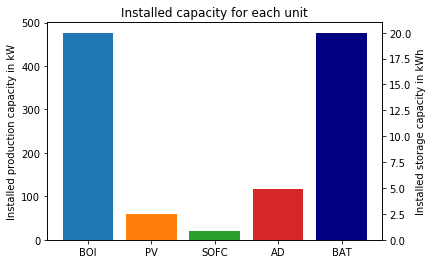

In [166]:
plot_unit_results(var_result_time_indep, Units, Units_storage, Color_code)
plt.show()

SyntaxError: unexpected EOF while parsing (<ipython-input-167-530220dfbe39>, line 2)

In [178]:
V_meta['Header'] = ['Name', 'Value', 'Lower Bound', 'Upper Bound', 'Units', 'Description']

In [179]:
def var_time_indep_summary(m, var_result_time_indep, V_meta):
    dic = {}
    for v in var_result_time_indep:
        dic[v] = [m.getVarByName(v).x]
        dic[v] += [m.getVarByName(v).lb, m.getVarByName(v).ub]
        if v in V_meta:
            dic[v] += V_meta[v]
            
    df = pd.DataFrame.from_dict(dic, orient='index')
    col = dict(zip([c for c in df.columns], V_meta['Header'][1:]))
    df.rename(columns = col, inplace = True)
    
    return df

In [210]:
var_name_time_dep

dict_keys(['prod[BOI][Heat]', 'cons[BOI][Gas]', 'prod[PV][Elec]', 'prod[BAT][Elec]', 'cons[BAT][Elec]', 'prod[SOFC][Elec]', 'prod[SOFC][Heat]', 'cons[SOFC][Gas]', 'cons[SOFC][Biogas]', 'prod[AD][Biogas]', 'cons[AD][Biomass]', 'cons[AD][Elec]', 'cons[AD][Heat]', 'unit_T[AD]', 'build_cons[Heat]', 'v[BOI][build]', 'v[BOI][AD]', 'v[SOFC][build]', 'v[SOFC][AD]', 'bat_SOC', 'bat_charge', 'bat_discharge', 'loss_biomass', 'build_T', 'penalty_t', 'comfort_delta_T', 'comfort_delta_T_abs', 'grid_elec_export_t', 'grid_elec_import_t', 'grid_gas_import_t', 'grid_gas_export_t'])

In [ ]:
def plot_stream_results():
    